# Python: price discrimination

In this notebook we consider a monopolist who can use second degree price discrimination. That is, the firm cannot observe a consumer's type. But the firm can make different offers that are attractive for different customers. Think of your mobile phone: do you want to pay either a low fee per month and high price per call or a high fee per month and low fee per call.


The European Commission does not like price discrimination and tries to abolish it. In this notebook we compare welfare under both price discrimination and non-discrimination (the case where the firm cannot price discriminate).

In [1]:
from scipy import optimize,arange
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

## utility and costs

Assume that a consumer of type $n$ derives utility $u(q,t,n) = nq-t$ from consuming a quality $q$ product at price $t$. The cost of producing quality $q$ is given by $c(q)=0.5q^2$.

Assume that there are two types of consumers $n_a > 0$ and $n_b > n_a$, where the fraction of $n_a$ consumers is given by $\phi \in [0,1]$.

The firm creates two versions of the product: quality $q_a$ and $q_b$ at price $t_a,t_b$ resp. If each type buys the version created for this type (we will have constraints to ensure this), profits $\pi$ and total welfare $W$ are given by

$$
\begin{split}
\pi & = \phi (t_a - 0.5q_a^2)+(1-\phi)(t_b - 0.5q_b^2)   \\
W &= \phi (n_a q_a - 0.5q_a^2)+(1-\phi)(n_b q_b - 0.5q_b^2)
\end{split}
$$

Hence, the efficient (welfare maximizing) quality levels satisfy $q_i^* = n_i$. 


In [3]:
def u(q,t,n):
    return n*q-t

def c(q):
    return 0.5*q**2

def buy(q,t,n): # buy = 1 if type n buys (q,t) and buy = 0 if n does not buy
    if u(q,t,n) < 0:
        buy = 0
    else:
        buy = 1
    return buy

na = 0.5
nb = 1.0

qa_fb = optimize.minimize_scalar(lambda x: -u(x,c(x),na)).x # the x-attribute of optimize.minimize_scalar gives the value
qb_fb = optimize.minimize_scalar(lambda x: -u(x,c(x),nb)).x # for which the function is minimized

print "Welfare maximizing qualities are given by: ", qa_fb, ", ", qb_fb

def profit(qa,ta,qb,tb,phi): # these are first best profits: no IC constraints
    return phi*buy(qa,ta,na)*(ta-c(qa))+(1-phi)*buy(qb,tb,nb)*(tb-c(qb))

def welfare(qa,ta,qb,tb,phi):
    return phi*buy(qa,ta,na)*(u(qa,ta,na)+ta-c(qa))+(1-phi)*buy(qb,tb,nb)*(u(qb,tb,nb)+tb-c(qb))

Welfare maximizing qualities are given by:  0.5 ,  1.0


## no discrimination

First, we consider the case where the firm cannot price discriminate: $q_a=q_b=q$ and $t_a=t_b=t$.

The firm has two choices: 

* set $t$ such that $u(q,t,n_a)=0$ and sell to both consumer types
* set $t$ such that $u(q,t,n_b)=0$ and sell to type $n_b$ only

When $\phi = 0.5$, profits are maximized by setting $q=1$ and selling to $n_b$ only:

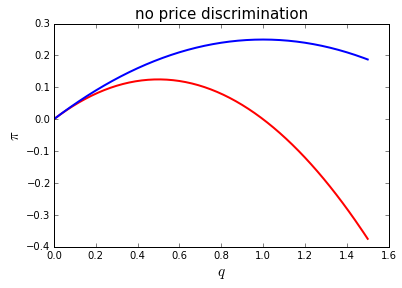

In [4]:
range_q = arange(0.0,1.51,0.01)
phi = 0.5
range_profits_a = [profit(q,na*q,q,na*q,phi) for q in range_q]
range_profits_b = [profit(q,nb*q,q,nb*q,phi) for q in range_q]

plt.clf()
 
plt.plot(range_q, range_profits_a,'-', color = 'r', linewidth = 2)
plt.plot(range_q, range_profits_b,'-', color = 'b', linewidth = 2)
plt.title("no price discrimination",fontsize = 15)
plt.xlabel("$q$",fontsize = 15)
plt.ylabel("$\pi$",fontsize = 15,rotation = 90)
#plt.xlim(0.0,1.0)
#plt.ylim(0.0,1.0)
plt.savefig('no_price_discrimination.png')

The following function determines the optimal $q$ and $t$ set by the firm in case of non-discrimination. As suggested by the figure, $\phi=0.5$ implies that $q=1$ and with $t=1$ only type $n_b$ buys the product.

In [6]:
def quality_non_discr(phi):
    qa = optimize.fminbound(lambda x: -profit(x,na*x,x,na*x,phi),0,2)
    qb = optimize.fminbound(lambda x: -profit(x,nb*x,x,nb*x,phi),0,2)
    if profit(qa,na*qa,qa,na*qa,phi) >= profit(qb,nb*qb,qb,nb*qb,phi):
        quality = qa
        t = u(qa,0,na)
    else:
        quality = qb
        t = u(qb,0,nb)
    return [quality,t]

print "optimal quality and price are given by:", quality_non_discr(0.5)
    
    

optimal quality and price are given by: [0.99999999999999989, 0.99999999999999989]


## price discrimination

When the firm can price discriminate, it needs to take 4 constraints into account:

* two Individual Rationality (IR) constraints:

$$
\begin{split}
u(q_a,t_a,n_a) &\geq 0 \\
u(q_b,t_b,n_b) &\geq 0
\end{split}
$$

* two incentive compatibility (IC) constraints:

$$
\begin{split}
u(q_a,t_a,n_a) &\geq u(q_b,t_b,n_a) \\
u(q_b,t_b,n_b) &\geq u(q_a,t_a,n_b)
\end{split}
$$


The IR constraints make sure that both types want to buy at all. The IC constraints make sure that types buy the "right" product (i.e. the product meant for them).

As shown in the lecture, with $n_b > n_a$, $IR_a$ and $IC_b$ are binding. Hence, $t_a = n_a q_a$ and $t_b = n_b q_b - (n_b-n_a)q_a$.

Further, we know from the lecture that $q_b = q_b^*$: first best quality for the highest type ("no distortion at the top"). 

Quality $q_a$ then solves

$$
\max_q \phi(n_a q -c(q))+(1-\phi)(n_b q_b^* - (n_b-n_a)q - c(q_b^*))
$$


In [7]:
def quality_discr(phi):
    nh = max(na,nb)
    nl = min(na,nb)
    opt_h = optimize.minimize_scalar(lambda x: -u(x,c(x),nh)) # first best quality for the highest type
    qh = opt_h.x 
    opt_l = optimize.fminbound(lambda x: -(phi*(u(x,0,nl)-c(x))+(1-phi)*(u(qh,0,nh)-u(x,u(x,0,nl),nh)-c(qh))),0,qh)
    ql = opt_l
    tl = u(ql,0,nl)
    th = u(qh,0,nh)-u(ql,u(ql,0,nl),nh)
    return [ql,tl,qh,th]

For $\phi =0.5$, the low type is not served: both $q$ and $t$ are (basically) zero. The high type gets efficient quality $q_b=q_b^*=1.0$ at $t=1.0$.

* Why do we find $q_a =0$; a positive profit can be made selling $q_a>0$ at $t_a>0$ to $n_a$?

In [9]:
quality_discr(0.5)

[5.9608609865491405e-06, 2.9804304932745702e-06, 1.0, 0.99999701956950671]

We can define a function to check whether all constraints are satisfied. In this function, the variables `ira, ica, irb, icb` are booleans. A boolean takes on two values `True` (1) or `False` (0). Using `and` and `or` booleans can be combined.

To illustrate, `True and False = False` while `True or False = True`.

At $\phi =0.5$ the menu generated by the function `quality_discr` satisfies all four constraints (as it should):

In [10]:
def check(menu):
    qa = menu[0]
    ta = menu[1]
    qb = menu[2]
    tb = menu[3]
    ira = (u(qa,ta,na) >= 0)
    ica = (u(qa,ta,na) >= u(qb,tb,na))    
    irb = (u(qb,tb,nb) >= 0)
    icb = (u(qb,tb,nb) >= u(qa,ta,nb))
    return (ira and ica and irb and icb)

check(quality_discr(0.5))


True

Next we plot the quality level for the low type as a function of $\phi$.

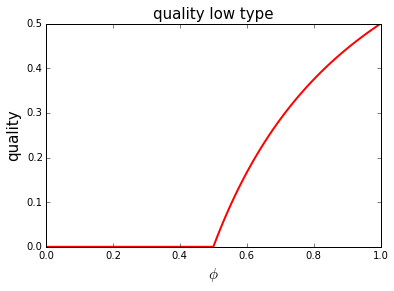

In [11]:
range_phi = arange(0.0,1.01,0.01)
range_ql = [quality_discr(phi)[0] for phi in range_phi]

plt.clf()
 
plt.plot(range_phi, range_ql,'-', color = 'r', linewidth = 2)

plt.title("quality low type",fontsize = 15)
plt.xlabel("$\phi$",fontsize = 15)
plt.ylabel("quality",fontsize = 15,rotation = 90)
#plt.xlim(0.0,1.0)
#plt.ylim(0.0,1.0)
plt.savefig('price_discrimination.png')


* Why is quality for the low type increasing in $\phi$?
* What happens to $q_b$ as a function of $\phi$?
* What is the quality level $q_a$ at $\phi =1.0$? Why?

## welfare

Finally, we compare welfare under discrimination and non-discrimination. We plot welfare in each case as a function of $\phi$. For each $\phi$ we consider the profit maximizing quality and price chosen by the firm.

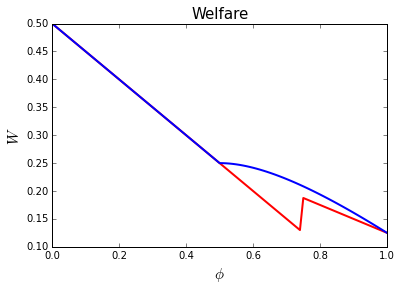

In [12]:
range_phi = arange(0.0,1.01,0.01)
range_W_non_disrc = [welfare(quality_non_discr(phi)[0],quality_non_discr(phi)[1],quality_non_discr(phi)[0],quality_non_discr(phi)[1],phi) for phi in range_phi]
range_W_discr = [welfare(quality_discr(phi)[0],quality_discr(phi)[1],quality_discr(phi)[2],quality_discr(phi)[3],phi) for phi in range_phi]

plt.clf()
 
plt.plot(range_phi, range_W_non_disrc,'-', color = 'r', linewidth = 2)
plt.plot(range_phi, range_W_discr,'-', color = 'b', linewidth = 2)


plt.title("Welfare",fontsize = 15)
plt.xlabel("$\phi$",fontsize = 15)
plt.ylabel("$W$",fontsize = 15,rotation = 90)
#plt.xlim(0.0,1.0)
#plt.ylim(0.0,1.0)
plt.savefig('Welfare_price_discrimination.png')

* Why do the welfare levels of discrimination and non-discrimination coincide for $\phi \leq 0.5$?
* Why is welfare higher under discrimination than non-discrimination for $\phi > 0.5$?
* What explains the jump in welfare for the non-discrimination case around $\phi = 0.75$? What happens here?
* Why do the two welfare levels coincide at $\phi = 1.0$?
* What do you think of the European Commision's bias against price discrimination?